# Статистический анализ данных. Проект GoFast

Данных о пользователях, их поездках и подписках.
users_go.csv
- user_id	уникальный идентификатор пользователя
- name	имя пользователя
- age	возраст
- city	город
- subscription_type	тип подписки (free, ultra)

Поездки.
rides_go.csv
- user_id	уникальный идентификатор пользователя
- distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date	дата совершения поездки

Подписки. 
subscriptions_go.csv
- subscription_type	тип подписки
- minute_price	стоимость одной минуты поездки по данной подписке
- start_ride_price	стоимость начала поездки
- subscription_fee	стоимость ежемесячного платежа

## Проверить гипотезы

- Тратят ли пользователи с подпиской больше времени на поездки?
- Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 
- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
- Какой тест понадобится для проверки гипотезы о значимом снижении количества обращений в техподдержку после обновления сервера, с которыми взаимодействует мобильное приложение?


## Построить распределения

- Акция с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. Какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %, при том что после бесплатного пробного периода подписку продлевают 10 % пользователей?
- Рассылка клиентам push-уведомления в мобильном приложении. Уведомления открывают около 40 % получивших клиентов. Планируется разослать 1 млн уведомлений. Построить примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import binom, nbinom, poisson
from math import factorial

#### Шаг 1. Загрузка данных

In [4]:
#df_rides = pd.read_csv('/datasets/rides_go.csv')
#df_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
#df_users = pd.read_csv('/datasets/users_go.csv')


df_rides = pd.read_csv('C:\\Users\\kushn\\Documents\\Python_trainings\\Yandex_DS\\Statistic_GoFast\\rides_go.csv')
df_subscriptions = pd.read_csv('C:\\Users\\kushn\\Documents\\Python_trainings\\Yandex_DS\\Statistic_GoFast\\subscriptions_go.csv')
df_users = pd.read_csv('C:\\Users\\kushn\\Documents\\Python_trainings\\Yandex_DS\\Statistic_GoFast\\users_go.csv')

In [5]:
df_rides.head(1)

,user_id,distance,duration,date
0,1,4409.91914,25.599769,2021-01-01


In [6]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Датафрейм df_rides содержит 18068 строк с 4 столбцами и типами данных:
 -   user_id   -   int64         
 -   distance  -   float64       
 -   duration  -   float64       
 -   date      -   object

In [7]:
df_subscriptions.head(1)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0


In [8]:
df_subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


Датафрейм df_subscriptions содержит 2 строки с 4 столбцами и типами данных:
-   subscription_type  -     object
-   minute_price       -      int64 
-   start_ride_price   -      int64 
-   subscription_fee   -      int64 

In [9]:
df_users.head(1)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra


In [10]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Датафрейм df_userd содержит 1565 строк с 5 столбцами и типами данных:
-   user_id            -  int64 
-   name               -   object
-   age                -   int64 
-   city               -   object
-   subscription_type  -   object

In [11]:
print(df_users.shape)
print(df_subscriptions.shape)
print(df_rides.shape)

(1565, 5)
(2, 4)
(18068, 4)


#### Шаг 2. Предобработка данных

In [12]:
def output_info (df):
    output = []
    for col in df.columns:
        non_null = len(df) - df[col].isna().sum()
        nul = len(df) - non_null
        unique = df[col].nunique()
        col_type = str(df[col].dtype)
        output.append([col, non_null, nul, unique, col_type])
    output = pd.DataFrame(output)
    output.columns = ['col_name','non-null_values','null_values', 'unique', 'dtype']
    return output

In [13]:
output_info(df_rides)

,col_name,non-null_values,null_values,unique,dtype
0,user_id,18068,0,1534,int64
1,distance,18068,0,18068,float64
2,duration,18068,0,17974,float64
3,date,18068,0,364,object


проверим полные дубли

In [14]:
df_rides.duplicated().sum()

0

Исправим формат даты

In [15]:
df_rides['date'] = pd.to_datetime(df_rides['date'], format='%Y-%m-%d')

In [16]:
df_rides['date'].describe()#datetime_is_numeric=True

count                            18068
mean     2021-06-30 19:47:21.266327296
min                2021-01-01 00:00:00
25%                2021-04-02 00:00:00
50%                2021-06-30 00:00:00
75%                2021-09-28 00:00:00
max                2021-12-30 00:00:00
Name: date, dtype: object

добавим колонку месяц

In [17]:
df_rides['month'] = df_rides['date'].dt.month

In [18]:
df_rides.head(1)

,user_id,distance,duration,date,month
0,1,4409.91914,25.599769,2021-01-01,1


In [19]:
output_info(df_users)

,col_name,non-null_values,null_values,unique,dtype
0,user_id,1565,0,1534,int64
1,name,1565,0,194,object
2,age,1565,0,29,int64
3,city,1565,0,8,object
4,subscription_type,1565,0,2,object


проверим полные дубли

In [20]:
df_users.duplicated().sum()

31

In [21]:
df_users.drop_duplicates(inplace=True)

In [22]:
df_users.duplicated().sum()

0

In [23]:
print(df_users.shape)
print(df_subscriptions.shape)
print(df_rides.shape)

(1534, 5)
(2, 4)
(18068, 5)


<b>Промежуточные выводы</b>

Получены 3 датафрейма
- df_users - (1565, 5)
- df_subscriptions - (2, 4)
- df_rides.shape - (18068, 4)



- `df_users` Удалены 31 полных дубля, новая размерность - (1534, 5)
- `df_subscriptions` - без изменений (2, 4)
- `df_rides.shape` Изменен формат данных колонки `date` со строковых данных на время, добавлена колонка с месяцом `month` - новая размерность (18068, 5)


#### Шаг 3. EDA

Города

In [24]:
def pie_graph (df, col):
    pie = df[col].value_counts().reset_index(name='counts')
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.pie(pie.counts, labels=pie[col], autopct='%1.1f%%')
    #ax.pie(pie.counts, labels=pie['index'], autopct='%1.1f%%')
    plt.show()

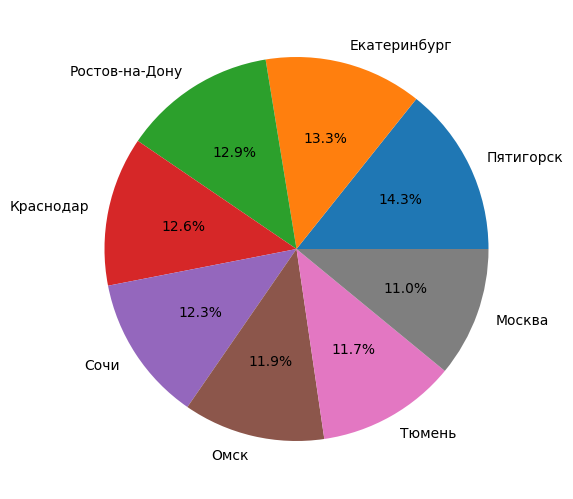

In [25]:
pie_graph(df_users, 'city')

,city,amount
0,Пятигорск,219
1,Екатеринбург,204
2,Ростов-на-Дону,198
3,Краснодар,193
4,Сочи,189
5,Омск,183
6,Тюмень,180
7,Москва,168


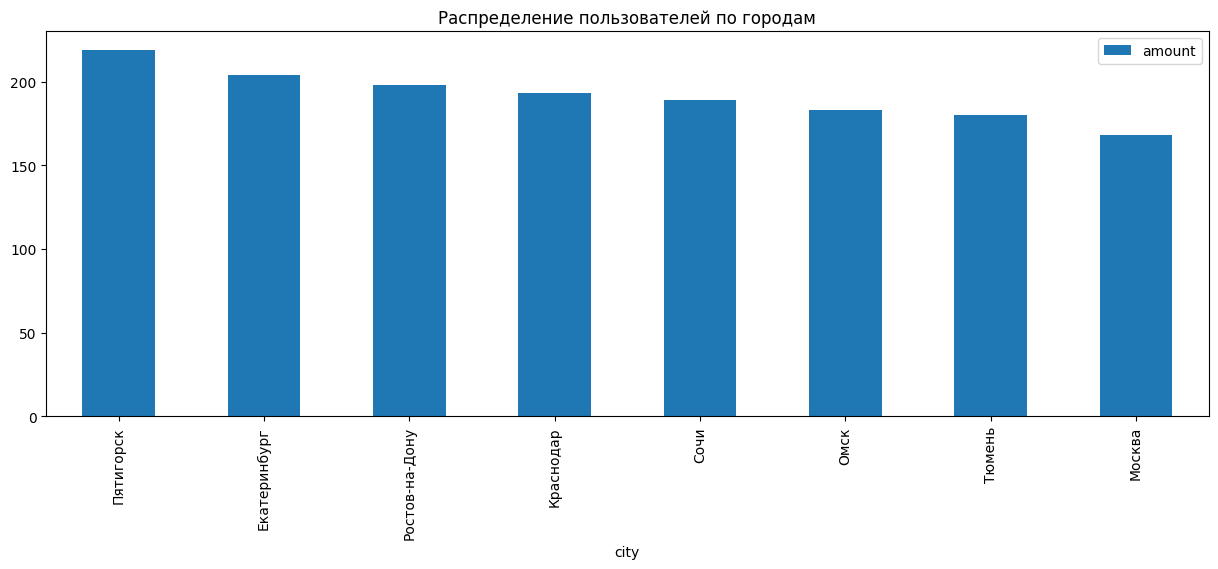

In [26]:
cities = pd.DataFrame(df_users['city']
.value_counts())\
    .reset_index()\
        .rename(columns={'count':'amount'})
    
cities.plot.bar(
    x ='city', figsize=(15,5),
    title='Распределение пользователей по городам')
cities

Пользователи представлены из 8 городов
- наибольшее количество 219 Пятигорск
- наименьшее 168 Москва

Распределение по типу подписки

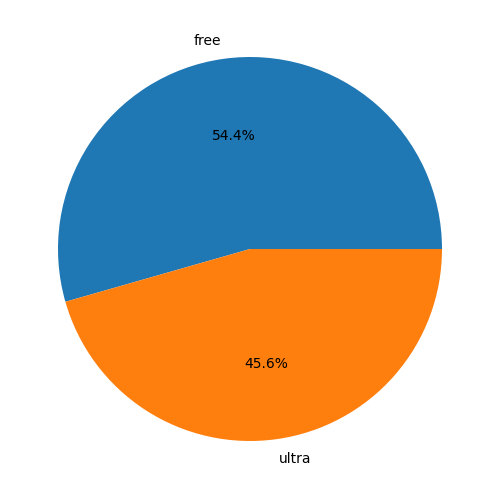

In [27]:
pie_graph(df_users, 'subscription_type')

In [28]:
    pd.DataFrame(df_users['subscription_type'].value_counts()).reset_index()
    #.rename(columns={'index':'subscription_type', 'subscription_type':'amount'})

,subscription_type,count
0,free,835
1,ultra,699


Количество пользователей с подпиской и без:
- 835 без подписки (54%)
- 699 без подниски (46%)

Возраст пользователей

In [29]:
df_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [30]:
pd.DataFrame(pd.cut(df_users['age'],
       [10, 18, 30, 40, 50],
       right = True,
       labels=['<18','18+','30+','40+']).value_counts(sort=False))

,count
age,
<18,125
18+,1234
30+,174
40+,1


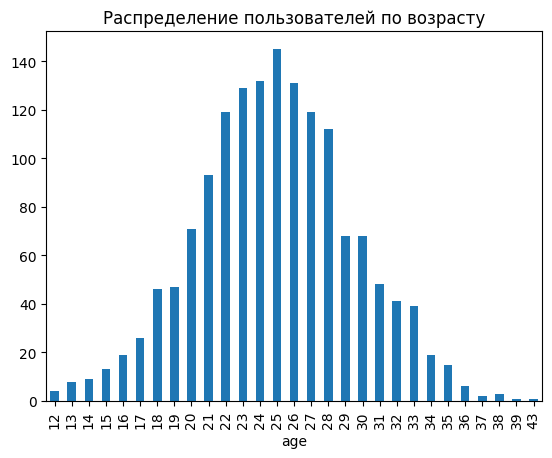

In [31]:
plt.title('Распределение пользователей по возрасту')
df_users['age'].value_counts().sort_index().plot.bar();

Средний возраст пользователя и самый частый 25 лет

Дистанции поездок

In [32]:
df_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

In [33]:
s_temp_01 = df_rides.assign(dist_group = pd.cut(
    df_rides['distance'],
    bins = 3,
        labels=['короткие','средние','длинные']))\
            .groupby('dist_group')['distance'].mean().round(0)


C:\Users\kushn\AppData\Local\Temp\ipykernel_9840\606428895.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('dist_group')['distance'].mean().round(0)


In [34]:
s_temp_02 = pd.cut(
    df_rides['distance'],
    bins = 3,
    labels=['короткие','средние','длинные']).value_counts(sort=False)

In [35]:
pd.concat([s_temp_01, s_temp_02], axis=1)\
    .rename(columns={'distance':'mean', 'count':'count'})


,mean,count
короткие,1435.0,3747
средние,3395.0,13514
длинные,5241.0,807


In [36]:
def distr_graph (df, col, title, xlabel):
    x = df[col]
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.kdeplot(x, color='red', ax=ax)
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    Mean = x.mean()
    Median = x.median()
    sdev = x.std()
    left = Mean - sdev
    right = Mean + sdev
    plt.title(title,fontsize=14)
    plt.xlabel(xlabel,fontsize=10)
    plt.ylabel("Плотность распределения",fontsize=10)
    ax.vlines(Mean, 0, np.interp(Mean, xs, ys), label='Mean', color='blue', ls=':')
    ax.vlines(Median, 0, np.interp(Median, xs, ys),label='Median', color='green', ls=':')
    ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, alpha=0.2)
    plt.legend()
    plt.show()

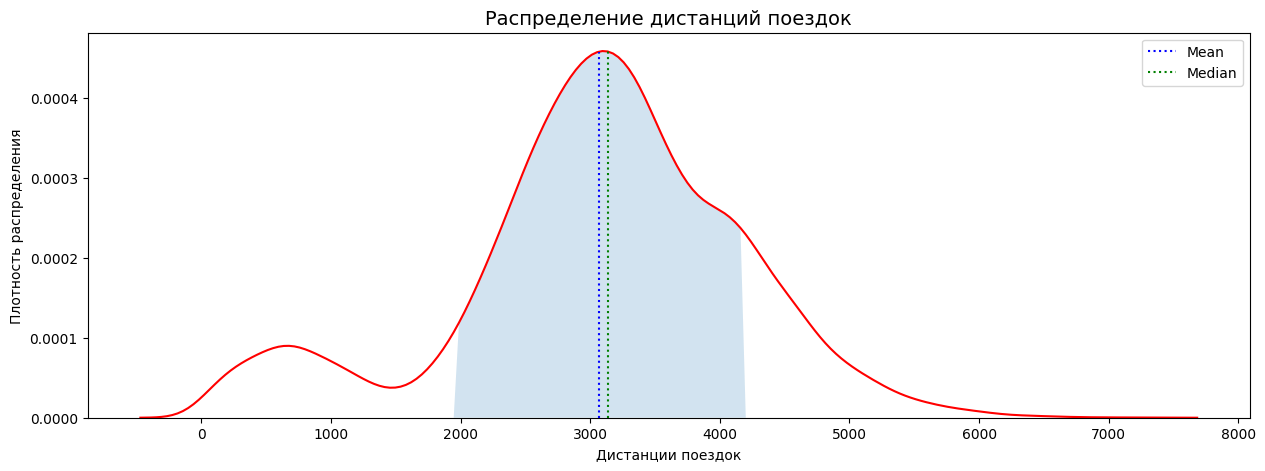

In [37]:
distr_graph(df_rides, 'distance', 'Распределение дистанций поездок', 'Дистанции поездок')

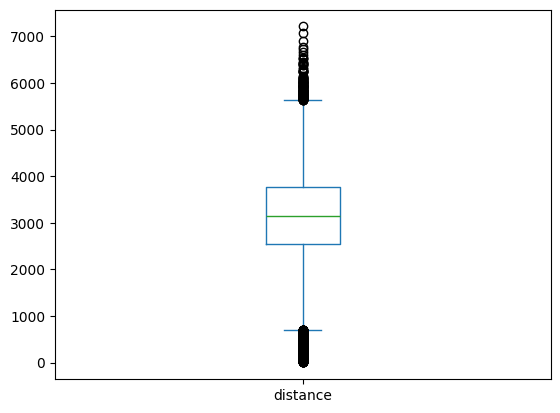

In [38]:
df_rides['distance'].plot.box();

In [39]:
q1,q2,q3 = np.quantile(df_rides['distance'], [.25,.5,.75])
iqr = q3 - q1

In [40]:
df_rides.assign(
    anomaly_min = df_rides['distance'] < (q1 - 1.5 *iqr))\
        .query('anomaly_min == True')['anomaly_min'].sum()

910

In [41]:
df_rides.assign(
    anomaly_max = df_rides['distance'] > (q3 + 1.5 *iqr))\
        .query('anomaly_max == True')['anomaly_max'].sum()

126

Время поездок

In [42]:
df_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

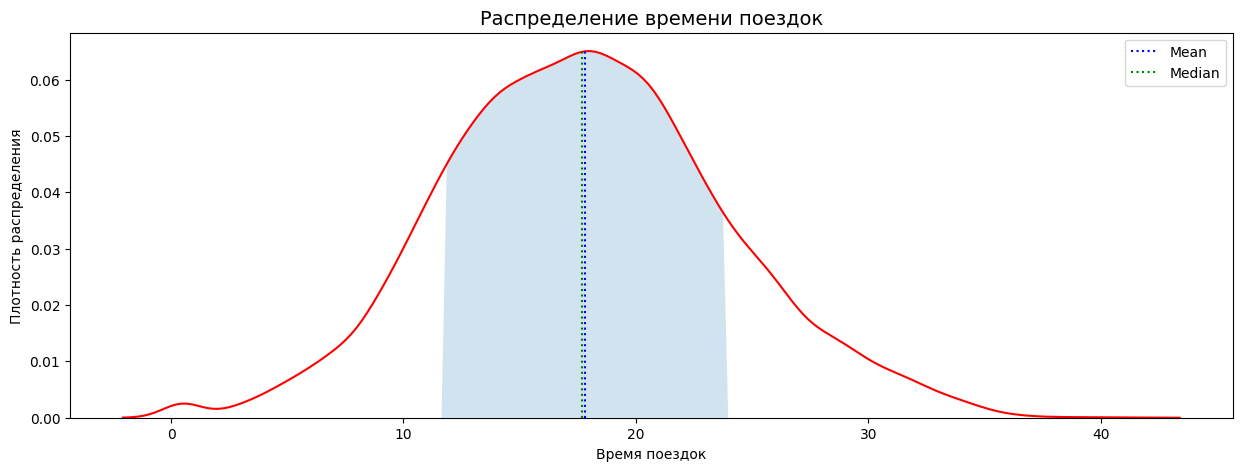

In [43]:
distr_graph(df_rides, 'duration', 'Распределение времени поездок', 'Время поездок')

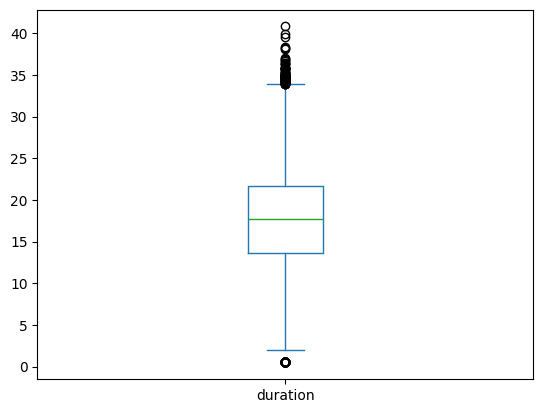

In [44]:
df_rides['duration'].plot.box();

Средняя скорость поездки

In [45]:
df_rides = df_rides.assign(velocity = lambda x: x['distance'] / x['duration'])
df_rides['velocity'].describe()

count    18068.000000
mean       229.754352
std        735.936479
min          0.085552
25%        135.464046
50%        170.852249
75%        215.496668
max      14422.015489
Name: velocity, dtype: float64

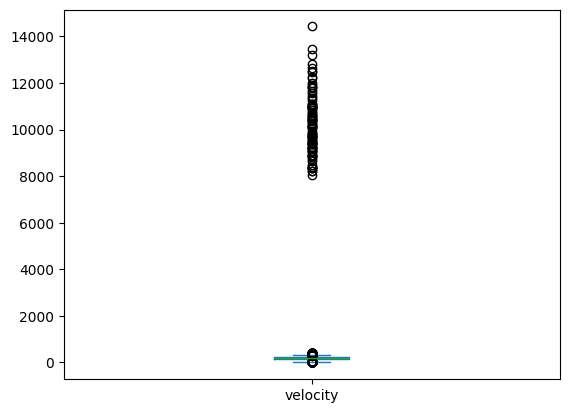

In [46]:
df_rides['velocity'].plot.box();

In [47]:
q1,q3 = np.quantile(df_rides['velocity'],[.25,.75])
iqr = q3 - q1 

In [48]:
df_rides.assign(
    anomaly_max = df_rides['velocity'] > (q3 + 1.5 *iqr))\
        .query('anomaly_max == True')['anomaly_max'].sum()

415

In [49]:
df_rides.assign(
    anomaly_min = df_rides['velocity'] < (q1 - 1.5 *iqr))\
        .query('anomaly_min == True')['anomaly_min'].sum()

99

Видим явные выбросы в районе скорости 8000 метров/минута

In [50]:
df_rides.query('velocity > 8000')['velocity'].count()

95

95 строк с аномальными данными по вермени поездки в 30 и менее секунд и скоростью более 8000 м\мин

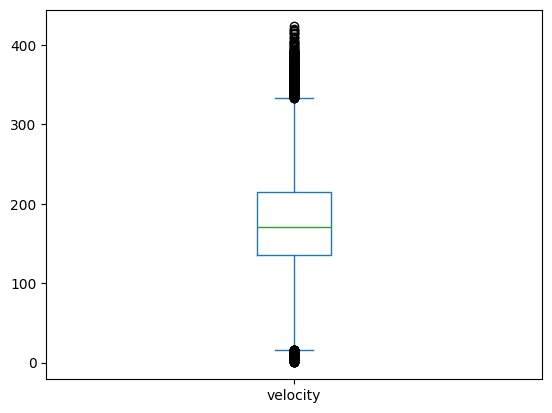

In [51]:
df_rides.query('velocity < 8000')['velocity'].plot.box();

In [52]:
df_rides.drop(columns=['velocity'], inplace=True)

#### Шаг 4. Объединение данных

In [53]:
print(df_rides.shape)
df_users.shape

(18068, 5)


(1534, 5)

In [54]:
df = df_users.merge(df_rides, on='user_id', how='left')

In [55]:
df.head(3)

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4


In [56]:
print(df.shape)
df_subscriptions.shape

(18068, 9)


(2, 4)

In [57]:
df = df.merge(df_subscriptions, on=['subscription_type'], how='left')

In [58]:
print(df.shape)
df.head(3)

(18068, 12)


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199


In [59]:
output_info(df)

,col_name,non-null_values,null_values,unique,dtype
0,user_id,18068,0,1534,int64
1,name,18068,0,194,object
2,age,18068,0,29,int64
3,city,18068,0,8,object
4,subscription_type,18068,0,2,object
5,distance,18068,0,18068,float64
6,duration,18068,0,17974,float64
7,date,18068,0,364,datetime64[ns]
8,month,18068,0,12,int32
9,minute_price,18068,0,2,int64


- Первым этапом провели объединение `df_rides (18068, 5)` и `df_users (1534, 5)` по общей колонке `user_id`
- Вторым этапом получившийся датафрейм `df (18068, 9)` объединили с `df_subscriptions (2, 4)` по общей колонке `subscription_type`
- Объединение прошло успешно датафрейм `df (18068, 12)` не содержит пропусков или дублей

In [60]:
df_free = df.query('subscription_type == "free"')
df_ultra = df.query('subscription_type == "ultra"')

In [61]:
#print('Количество поездок тариф "ultra":', len(df_ultra))
#print('Средняя дистанция тариф "ultra":', df_ultra['distance'].mean().round(0))
#print('Среднее время тариф "ultra":', df_ultra['duration'].mean().round(0))

In [62]:
df_compare = df.pivot_table(
    index='subscription_type',
    values=['distance', 'duration'],
    aggfunc=['mean', 'median', 'max', 'std'])
df_compare.style.format("{:.0f}")

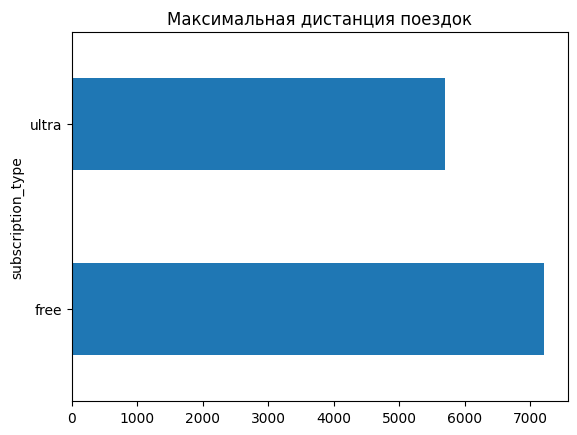

In [63]:
df_compare['max'].plot(kind = "barh", y = "distance", legend = False, title = "Максимальная дистанция поездок");

In [64]:
df.query('distance < 500').pivot_table\
(index='subscription_type', values=['distance'], aggfunc=['count']).style.format("{:.0f}")

,count
,distance
subscription_type,
free,547
ultra,15


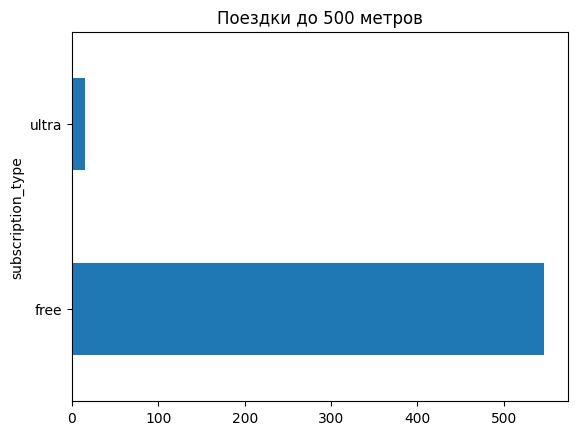

In [65]:
(
    df.query('distance < 500')
    .pivot_table(index='subscription_type', values=['distance'], aggfunc=['count'])
    .plot(kind = "barh", y = ["count"], legend = False, title = "Поездки до 500 метров")
);

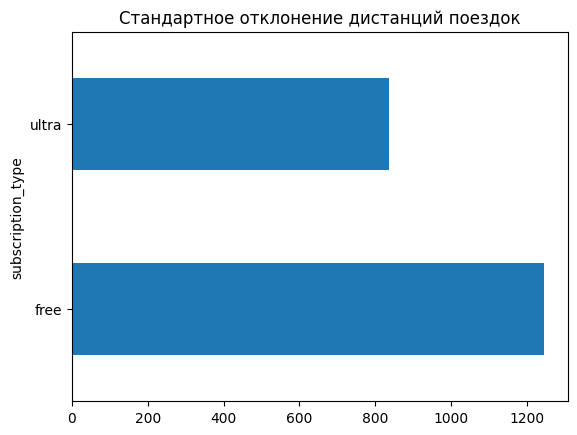

In [66]:
df_compare['std'].plot(kind = "barh", y = "distance", legend = False, title = "Стандартное отклонение дистанций поездок");

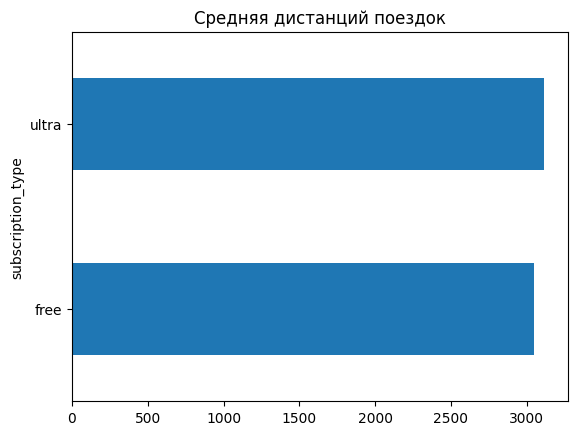

In [67]:
df_compare['mean'].plot(kind = "barh", y = "distance", legend = False, title = "Средняя дистанций поездок");

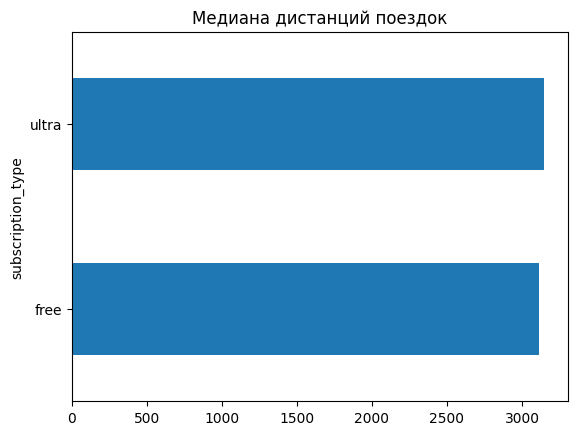

In [68]:
df_compare['median'].plot(kind = "barh", y = "distance", legend = False, title = "Медиана дистанций поездок");

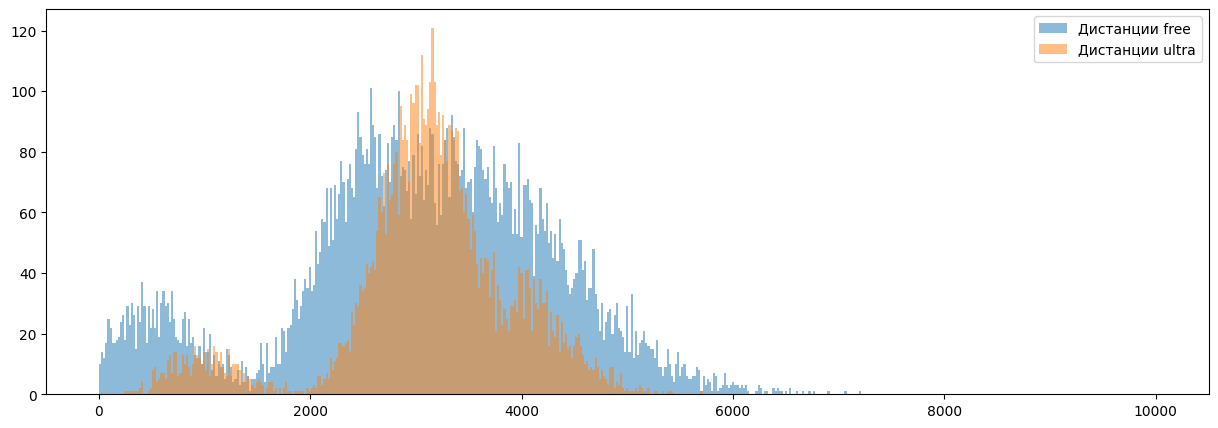

In [69]:
plt.figure(figsize=(15,5))

bins = np.linspace(0, 10000, 500)

plt.hist(df_free['distance'], bins, alpha=0.5, label='Дистанции free')
plt.hist(df_ultra['distance'], bins, alpha=0.5, label='Дистанции ultra')

plt.legend(loc='upper right')
plt.show()

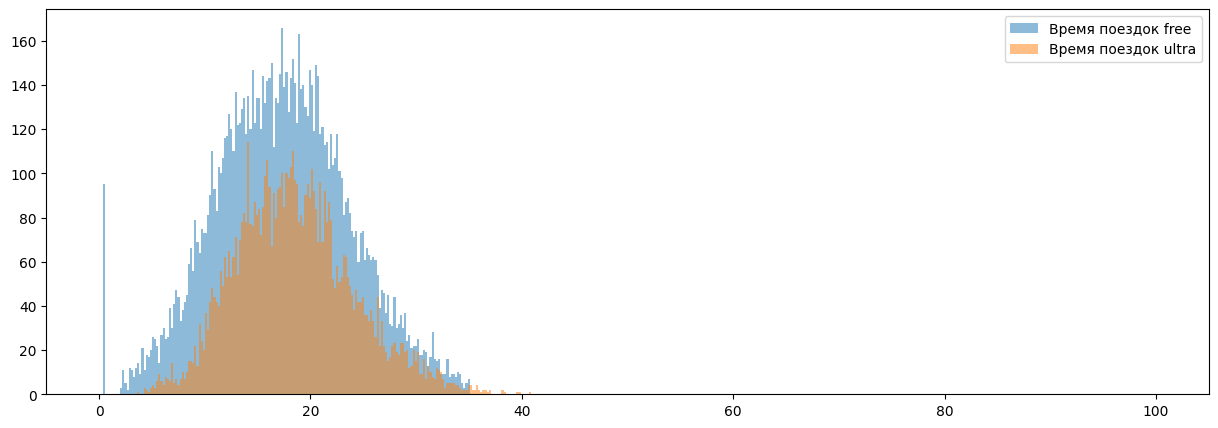

In [70]:
plt.figure(figsize=(15,5))
bins = np.linspace(0, 100, 500)

plt.hist(df_free['duration'], bins, alpha=0.5, label='Время поездок free')
plt.hist(df_ultra['duration'], bins, alpha=0.5, label='Время поездок ultra')

plt.legend(loc='upper right')
plt.show()

Анализ дистанций поездок:
- средние и медианные значения примерно одинаковые у обоих тарифов около 3100 метров
- однако разброс значений у тарифа free в 1.5 раза выше 1246 и 837 метров
- у тарифа free больше поездок на коротки и длинные расстояния

#### Шаг 5. Подсчет выручки

In [71]:
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [72]:
df['duration'] = np.ceil(df['duration'])
df['distance'] = round(df['distance'],0)
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4410.0,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2618.0,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.0,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2695.0,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4029.0,27.0,2021-08-28,8,6,0,199


In [73]:
df_sales = df.pivot_table(
    index=['user_id','subscription_type', 'month', 'minute_price', 'start_ride_price', 'subscription_fee'],
    values=['distance', 'duration'],
    aggfunc=['sum','count'])

In [74]:
df_sales.head(1)

sum  \
                                                                               distance   
user_id subscription_type month minute_price start_ride_price subscription_fee            
1       ultra             1     6            0                199                7028.0   

                                                                                         \
                                                                               duration   
user_id subscription_type month minute_price start_ride_price subscription_fee            
1       ultra             1     6            0                199                  42.0   

                                                                                  count  \
                                                                               distance   
user_id subscription_type month minute_price start_ride_price subscription_fee            
1       ultra             1     6            0                199                     2   

                                                                                         
                                                                               duration  
user_id subscription_type month minute_price start_ride_price subscription_fee           
1       ultra             1     6            0                199                     2

In [75]:
df_sales.columns = df_sales.columns.map(''.join)
df_sales.columns

Index(['sumdistance', 'sumduration', 'countdistance', 'countduration'], dtype='object')

In [76]:
df_sales.drop('countduration', axis = 1, inplace = True)

df_sales.rename(columns={'sumdistance':'sum_distance',
                        'sumduration':'sum_duration',
                        'countdistance':'rides_amount'},inplace=True)

In [77]:
print(len(df_sales))
df_sales.reset_index(inplace=True)
df_sales.head(3)

11331


,user_id,subscription_type,month,minute_price,start_ride_price,subscription_fee,sum_distance,sum_duration,rides_amount
0,1,ultra,1,6,0,199,7028.0,42.0,2
1,1,ultra,4,6,0,199,754.0,7.0,1
2,1,ultra,8,6,0,199,6724.0,46.0,2


In [78]:
df_sales_free = df_sales.query(
    'subscription_type == "free"').assign(
        sales = lambda x: x['start_ride_price'] * x['rides_amount'] + x['minute_price'] * x['sum_duration']
        )
df_sales_ultra = df_sales.query(
    'subscription_type == "ultra"').assign(
        sales = lambda x: x['subscription_fee'] + x['minute_price'] * x['sum_duration']
        )

In [79]:
df_sales_free['sales'].describe()

count    6798.000000
mean      328.641365
std       183.868330
min        58.000000
25%       194.000000
50%       274.000000
75%       428.000000
max      1444.000000
Name: sales, dtype: float64

In [80]:
df_sales_ultra['sales'].describe()

count    4533.000000
mean      362.792191
std        88.262737
min       223.000000
25%       301.000000
50%       337.000000
75%       409.000000
max       955.000000
Name: sales, dtype: float64

In [81]:
df_sales = pd.concat([df_sales_free, df_sales_ultra])
print(len(df_sales))
df_sales.sort_index().head(10)

11331


,user_id,subscription_type,month,minute_price,start_ride_price,subscription_fee,sum_distance,sum_duration,rides_amount,sales
0,1,ultra,1,6,0,199,7028.0,42.0,2,451.0
1,1,ultra,4,6,0,199,754.0,7.0,1,241.0
2,1,ultra,8,6,0,199,6724.0,46.0,2,475.0
3,1,ultra,10,6,0,199,5810.0,32.0,2,391.0
4,1,ultra,11,6,0,199,7004.0,56.0,3,535.0
5,1,ultra,12,6,0,199,6752.0,28.0,2,367.0
6,2,ultra,3,6,0,199,10188.0,63.0,3,577.0
7,2,ultra,4,6,0,199,6165.0,40.0,2,439.0
8,2,ultra,6,6,0,199,3255.0,14.0,1,283.0
9,2,ultra,7,6,0,199,6781.0,48.0,2,487.0


In [82]:
df_sales['sales'].describe()

count    11331.000000
mean       342.303504
std        153.875346
min         58.000000
25%        234.000000
50%        319.000000
75%        415.000000
max       1444.000000
Name: sales, dtype: float64

In [83]:
print(f"Общая выручка за год: {df_sales['sales'].sum():,.0f}")
print(f"Выручка тариф free: {df_sales_free['sales'].sum():,.0f}")
print(f"Выручка тариф ultra: {df_sales_ultra['sales'].sum():,.0f}")

Общая выручка за год: 3,878,641
Выручка тариф free: 2,234,104
Выручка тариф ultra: 1,644,537


#### Шаг 6. Проверка гипотез

##### 6.1 Гипотеза, что пользователи с подпиской тратят больше времени на поездки.

- mu1 - среднее время пользователей с подпиской
- mu2 - среднее время пользователей без подписки

- H0: mu1 = mu2
- H1: mu1 > mu2


In [84]:
samp_1 = list(df_ultra['duration'])
samp_2 = list(df_free['duration'])

alpha = .05
results = st.ttest_ind(samp_1, samp_2, alternative='greater')

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')


p-значение: 1.2804098316645613e-34
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу, поскольку проведенное T-тестиование выборок с 95% доверительным интервалом выявило различие 2ух средних.  Позьзователи с подпиской в среднем тратят больше времени в поездках, чем без подписки.

##### 6.2 Гипотеза, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. 

- H0: среднее расстояние пользователей с подпиской за одну поездку = 3130 метров
- H1: среднее расстояние пользователей с подпиской за одну поездку > 3130 метров


In [85]:
samp_1 = list(df.query('subscription_type == "ultra"')['distance'])
effective_dist = 3130

alpha = .05

results = st.ttest_1samp(samp_1, effective_dist, alternative='greater')

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 0.9195649894697724
Не отвергаем нулевую гипотезу


Не отвергаем нулевую гипотезу, что среднее растояние за одну поездку у пользователей с подпиской равно 3130 метров. Среднее расстояние поездок пользователей с тарифом ultra не завышено и является оптимальным с точки зрения износа самоката.

##### 6.3 Гипотеза, что помесячная выручка от пользователей с подпиской по месяцам выше чем выручка от пользователей без подписки. 

- mu1 - среднемесячная выручка от пользователя с подпиской
- mu2 - среднемесячная выручка от пользователя без подпиской

- H0: mu1 = mu2
- H1: mu1 > mu2


In [86]:
samp_1 = list(df_sales_ultra['sales'])
samp_2 = list(df_sales_free['sales'])

alpha = .05
results = st.ttest_ind(samp_1, samp_2, alternative='greater')

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Принимаем альтеранативную гипотезу, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

##### 6.4 Гипотеза о значимом снижении количества обращений в техподдержку после обновления сервера.


Необходимо провести тест о равенстве среднего значения после и до изменения:
- mu1 - среднее количество обращений пользователей после изменения
- mu2 - среднее количество обращений пользователей до изменения

- H0: mu1 = mu2
- H1: mu1 < mu2

`scipy.stats.ttest_rel()`

#### Шаг 7. Распределения

##### 7.1 Акция с раздачей промокодов на один бесплатный месяц подписки
- План минимум 100 существующих клиентов должны продлить эту подписку
- Вероятность продления 10%
- Вероятность невыполненния 5%

Необходимо построить отрицательную биномиальную функцию распределения. Описывает последовательность испытаний Бернулли, повторяющихся до тех пор, пока не произойдет предопределенное неслучайное число успешных результатов.

In [87]:
k = 100
q = 0.05
p = 0.1

n = nbinom.ppf(1-q, k, p) + k 
print(f'Необходимо провести акцию с вероятностью успха одного испытания в {p:.0%} \
среди {n:.0f} пользователей, чтобы получить {k} успехов с вероятностью исполнения в {1-q:.0%}')

Необходимо провести акцию с вероятностью успха одного испытания в 10% среди 1161 пользователей, чтобы получить 100 успехов с вероятностью исполнения в 95%


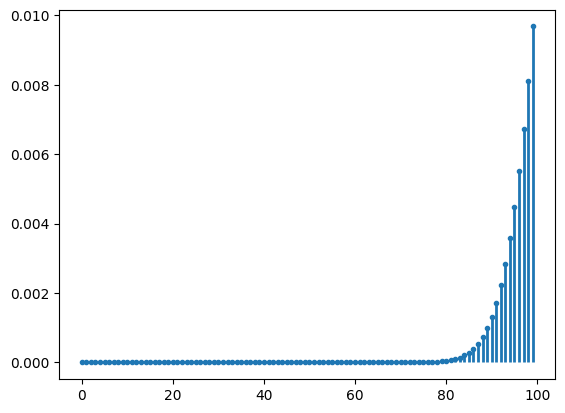

In [88]:
fig, ax = plt.subplots(1, 1)
x = np.arange(binom.ppf(q, n, p))
ax.plot(x, binom.pmf(x, n, p), 'o', ms=3)
ax.vlines(x, 0, binom.pmf(x, n, p), lw=2)
plt.show()

##### 7.2 Push-уведомления
- Рассылка 1 млн уведомлений
- Вероятность открытия уведомления 40%
- Оценить вероятность открытия увеомлений 399,5 тыс пользователями

Проверим можем ли мы провести аппроксимацию нормальным распределением

In [89]:
n = 1000000
p = 0.4
a = 399500
mu = n * p
sigma = np.sqrt(n * p * (1 - p))
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие выполняется')
else:
    print('Условие не выполняется')

Условие выполняется


Оценим вероятность события

In [90]:
distr = st.norm(mu, sigma)
q = distr.cdf(a)
print(f'Вероятность открытия {a:,.0f} пользователями после рассылки {n:,.0f} \
push-уведомлений с веорятностью открытия уведомления в {p:.0%}  равна {q:.0%}')

Вероятность открытия 399,500 пользователями после рассылки 1,000,000 push-уведомлений с веорятностью открытия уведомления в 40%  равна 15%


# Выводы

Было проведено исследование данных о поездках на самокатах компании GoFast. Данные содержат информацию:
- за 12 месяцев 2021 года
- о 1534 уникальных пользователях
- совершивших за этот период 18068 поездок

# Категориальные данные

Данные представлены из 8 городов

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>city</th>
      <th>counts</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Пятигорск</td>
      <td>219</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Екатеринбург</td>
      <td>204</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Ростов-на-Дону</td>
      <td>198</td>
    </tr>
    <tr>
      <th>3</th>
      <td>Краснодар</td>
      <td>193</td>
    </tr>
    <tr>
      <th>4</th>
      <td>Сочи</td>
      <td>189</td>
    </tr>
    <tr>
      <th>5</th>
      <td>Омск</td>
      <td>183</td>
    </tr>
    <tr>
      <th>6</th>
      <td>Тюмень</td>
      <td>180</td>
    </tr>
    <tr>
      <th>7</th>
      <td>Москва</td>
      <td>168</td>
    </tr>
  </tbody>
</table>
</div>

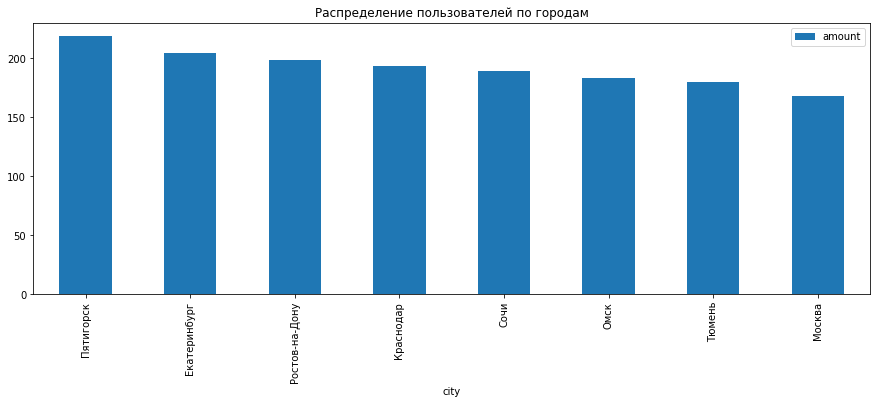

Соотношение пользователей с подпиской и без примерно равное

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>subscription_type</th>
      <th>counts</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>free</td>
      <td>835</td>
    </tr>
    <tr>
      <th>1</th>
      <td>ultra</td>
      <td>699</td>
    </tr>
  </tbody>
</table>
</div>

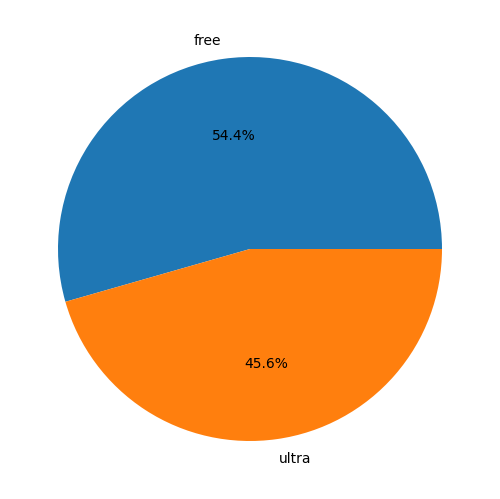

По возрастной характеристики пользователи разделились следующим образом:

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>count</th>
    </tr>
    <tr>
      <th>age</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>&lt;18</th>
      <td>125</td>
    </tr>
    <tr>
      <th>18+</th>
      <td>1234</td>
    </tr>
    <tr>
      <th>30+</th>
      <td>174</td>
    </tr>
    <tr>
      <th>40+</th>
      <td>1</td>
    </tr>
  </tbody>
</table>
</div>

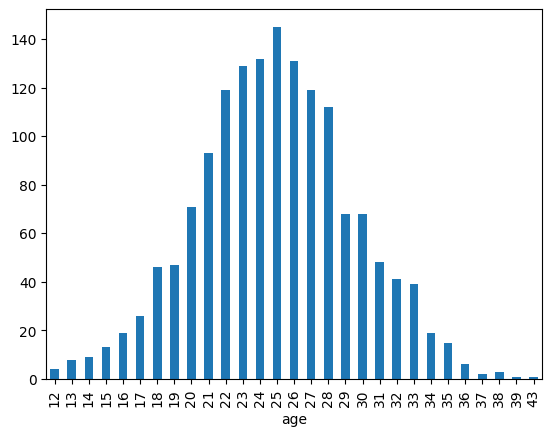

# Дистанции и вермя поездок

Средняя дистаниция поездки составила 3070 метров.

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>distance</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>count</th>
      <td>18068.000000</td>
    </tr>
    <tr>
      <th>mean</th>
      <td>3070.659976</td>
    </tr>
    <tr>
      <th>std</th>
      <td>1116.831209</td>
    </tr>
    <tr>
      <th>min</th>
      <td>0.855683</td>
    </tr>
    <tr>
      <th>25%</th>
      <td>2543.226360</td>
    </tr>
    <tr>
      <th>50%</th>
      <td>3133.609994</td>
    </tr>
    <tr>
      <th>75%</th>
      <td>3776.222735</td>
    </tr>
    <tr>
      <th>max</th>
      <td>7211.007745</td>
    </tr>
  </tbody>
</table>
</div>

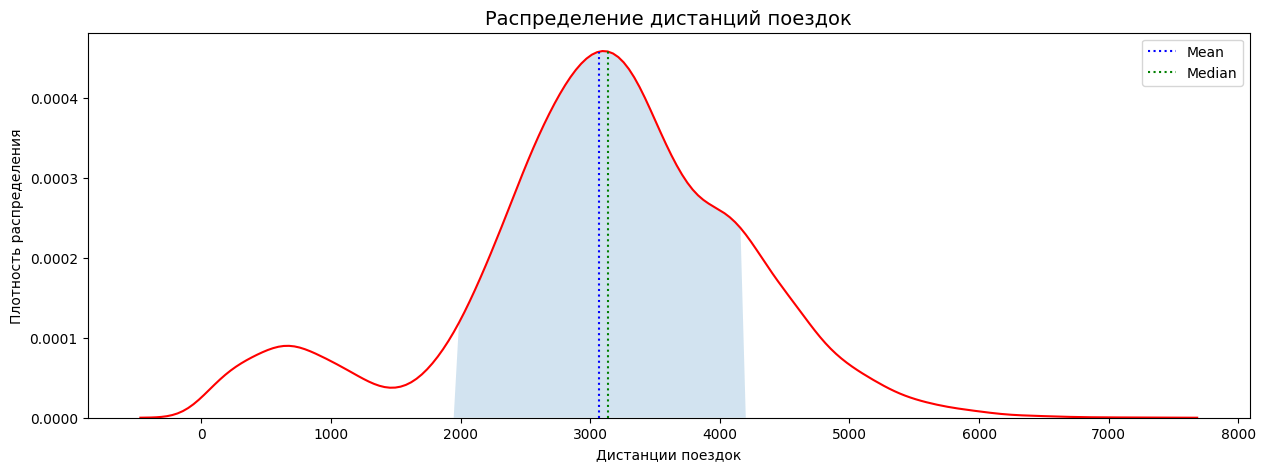

Среднее время поездки составило 18 минут.

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>duration</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>count</th>
      <td>18068.000000</td>
    </tr>
    <tr>
      <th>mean</th>
      <td>17.805011</td>
    </tr>
    <tr>
      <th>std</th>
      <td>6.091051</td>
    </tr>
    <tr>
      <th>min</th>
      <td>0.500000</td>
    </tr>
    <tr>
      <th>25%</th>
      <td>13.597563</td>
    </tr>
    <tr>
      <th>50%</th>
      <td>17.678395</td>
    </tr>
    <tr>
      <th>75%</th>
      <td>21.724800</td>
    </tr>
    <tr>
      <th>max</th>
      <td>40.823963</td>
    </tr>
  </tbody>
</table>
</div>

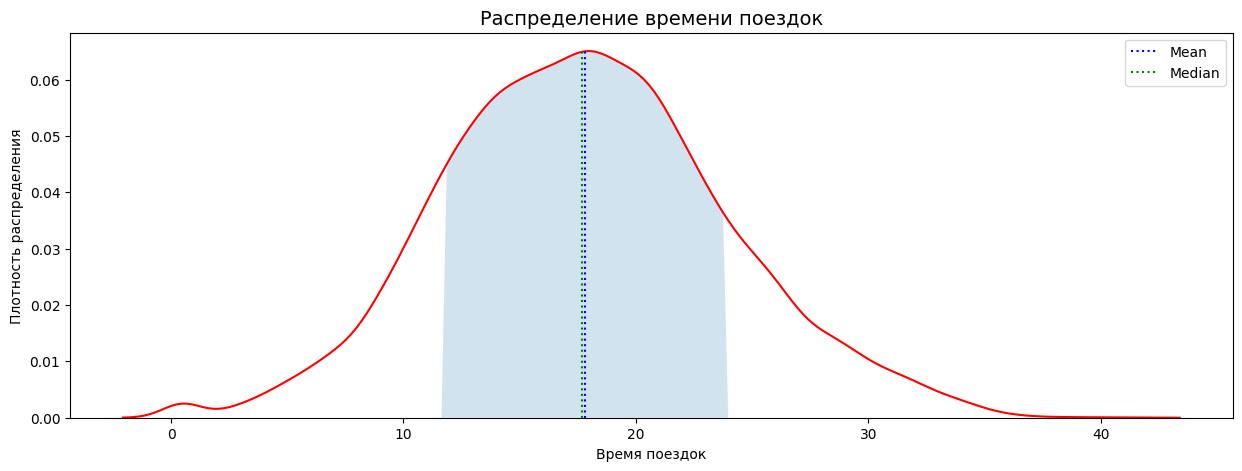

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>velocity</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>count</th>
      <td>18068.000000</td>
    </tr>
    <tr>
      <th>mean</th>
      <td>229.754352</td>
    </tr>
    <tr>
      <th>std</th>
      <td>735.936479</td>
    </tr>
    <tr>
      <th>min</th>
      <td>0.085552</td>
    </tr>
    <tr>
      <th>25%</th>
      <td>135.464046</td>
    </tr>
    <tr>
      <th>50%</th>
      <td>170.852249</td>
    </tr>
    <tr>
      <th>75%</th>
      <td>215.496668</td>
    </tr>
    <tr>
      <th>max</th>
      <td>14422.015489</td>
    </tr>
  </tbody>
</table>
</div>

Проведен поиск аномалий в столбцах дистаниции и время поездок. Определили среднюю скорость поездки делением дистанции на время.

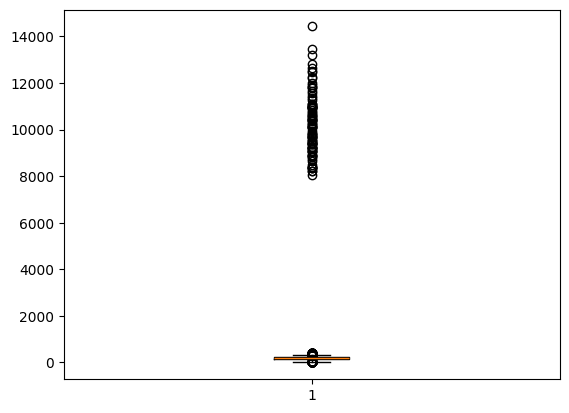

95 сток имеют аномальную скорость более 8000 м/мин со временем поездки мене 30 секунд.

# Сравнение тарифов free и ultra

Количество поездок по тарифу free было примерно в 2 раза больше чем тариф ultra. Среднее время поездки тарифа ultra 19 минут, а тарифа free 17 минут.

<style type="text/css">
</style>
<table id="T_777e0">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_777e0_level0_col0" class="col_heading level0 col0" colspan="2">mean</th>
      <th id="T_777e0_level0_col2" class="col_heading level0 col2" colspan="2">median</th>
      <th id="T_777e0_level0_col4" class="col_heading level0 col4" colspan="2">max</th>
      <th id="T_777e0_level0_col6" class="col_heading level0 col6" colspan="2">std</th>
    </tr>
    <tr>
      <th class="blank level1" >&nbsp;</th>
      <th id="T_777e0_level1_col0" class="col_heading level1 col0" >distance</th>
      <th id="T_777e0_level1_col1" class="col_heading level1 col1" >duration</th>
      <th id="T_777e0_level1_col2" class="col_heading level1 col2" >distance</th>
      <th id="T_777e0_level1_col3" class="col_heading level1 col3" >duration</th>
      <th id="T_777e0_level1_col4" class="col_heading level1 col4" >distance</th>
      <th id="T_777e0_level1_col5" class="col_heading level1 col5" >duration</th>
      <th id="T_777e0_level1_col6" class="col_heading level1 col6" >distance</th>
      <th id="T_777e0_level1_col7" class="col_heading level1 col7" >duration</th>
    </tr>
    <tr>
      <th class="index_name level0" >subscription_type</th>
      <th class="blank col0" >&nbsp;</th>
      <th class="blank col1" >&nbsp;</th>
      <th class="blank col2" >&nbsp;</th>
      <th class="blank col3" >&nbsp;</th>
      <th class="blank col4" >&nbsp;</th>
      <th class="blank col5" >&nbsp;</th>
      <th class="blank col6" >&nbsp;</th>
      <th class="blank col7" >&nbsp;</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_777e0_level0_row0" class="row_heading level0 row0" >free</th>
      <td id="T_777e0_row0_col0" class="data row0 col0" >3045</td>
      <td id="T_777e0_row0_col1" class="data row0 col1" >17</td>
      <td id="T_777e0_row0_col2" class="data row0 col2" >3115</td>
      <td id="T_777e0_row0_col3" class="data row0 col3" >17</td>
      <td id="T_777e0_row0_col4" class="data row0 col4" >7211</td>
      <td id="T_777e0_row0_col5" class="data row0 col5" >35</td>
      <td id="T_777e0_row0_col6" class="data row0 col6" >1246</td>
      <td id="T_777e0_row0_col7" class="data row0 col7" >6</td>
    </tr>
    <tr>
      <th id="T_777e0_level0_row1" class="row_heading level0 row1" >ultra</th>
      <td id="T_777e0_row1_col0" class="data row1 col0" >3115</td>
      <td id="T_777e0_row1_col1" class="data row1 col1" >19</td>
      <td id="T_777e0_row1_col2" class="data row1 col2" >3149</td>
      <td id="T_777e0_row1_col3" class="data row1 col3" >18</td>
      <td id="T_777e0_row1_col4" class="data row1 col4" >5700</td>
      <td id="T_777e0_row1_col5" class="data row1 col5" >41</td>
      <td id="T_777e0_row1_col6" class="data row1 col6" >837</td>
      <td id="T_777e0_row1_col7" class="data row1 col7" >6</td>
    </tr>
  </tbody>
</table>


<table><tr><td><img src='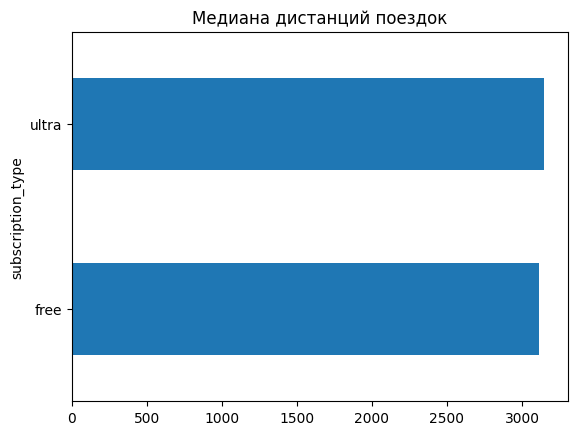'></td><td>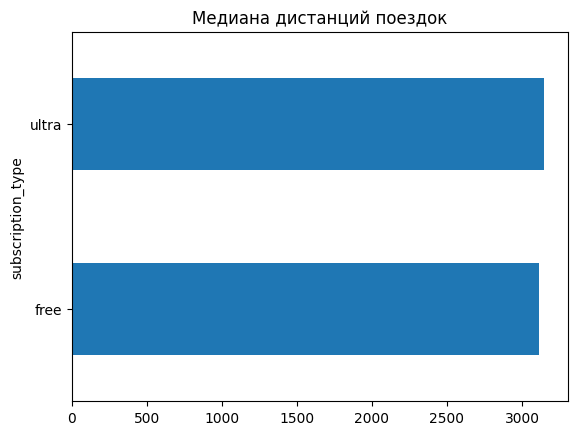</td></tr></table>

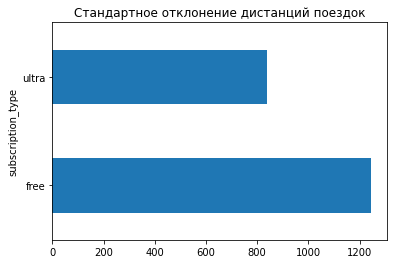

<table><tr><td><img src='attachment:image.png'></td><td><img src='attachment:image-2.png'></td></tr></table>

<table><tr><td><img src='attachment:image-3.png'></td><td><img src='attachment:image-4.png'></td></tr></table>

- средние и медианные значения примерно одинаковые у обоих тарифов около 3100 метров
- однако разброс значений у тарифа free в 1.5 раза выше 1246 и 837 метров
- у тарифа free больше поездок на коротки и длинные расстояния

# Выручка

Выручка компании за год составила:
- Общая выручка за год: 3,853,677
- Выручка тариф free:   2,215,080
- Выручка тариф ultra:  1,638,597

# Гипотезы

<b>Гипотеза, что пользователи с подпиской тратят больше времени на поездки.</b>

Провели сравнение среднего времени поездки двух независимых выборок (тариф free и ultra) по критерию Стьюдента. 
- С доверительной вероятностью в 95% можем утверждать, что позьзователи с подпиской в среднем тратят больше времени в поездках, чем без подписки.

<b>Гипотеза, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.</b>

Провели сравнение заданного средненго в 3130 метров cо средним выборки тарифа ultra по критерию Стьюдента.
- С доверительной вероятностью в 95% средняя дистанция поездки не превышает 3130 метров.

<b>Гипотеза, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.</b>

Провели сравнение помесячной средней выручки двух независимых выборок (тариф free и ultra) по критерию Стьюдента. 
- С доверительной вероятностью в 95% среднняя помесячная выручка при тарифу ultra выше.

<b>Гипотеза о значимом снижении количества обращений в техподдержку после обновления сервера.</b>

Необходимо провести тест о равенстве среднего значения до и после изменения:
- mu1 - среднее количество обращений пользователей до изменения
- mu2 - среднее количество обращений пользователей после изменения

- H0: mu1 = mu2
- H1: mu1 < mu2

`scipy.stats.ttest_rel()`

# Распределения

<b>Акция с раздачей промокодов на один бесплатный месяц подписки.</b>

Чтобы по окончанию акции получить 100 новых пользователей с подпиской с вероятностью успеха в 95% необходимо провести акцию  среди минимум <b>1161</b> пользователей с учетом расчетной конверсии в 10%

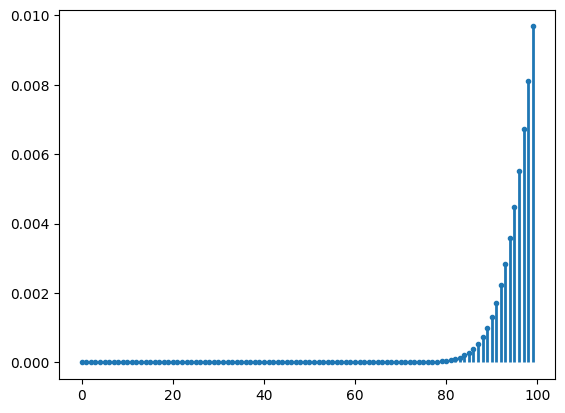

<b>Оценить вероятность открытия 399,5 тысячами пользователями push-уведомления после 1 млн. рассыкли при расчетной конверсии 40%</b>

Провели аппроксимацию биноминального распределения нормальным, поскольку  `mu +/-3*sigma` лежит на промежутке `[0, n]`

Вероятность открытия 399,500 пользователями после рассылки 1,000,000 push-уведомлений с веорятностью открытия уведомления в 40%  равна 15%

# Итоговые выводы

Анализ поездок пользователей GoFast:
-	1534 уникальных пользователя
-	из 8 городов
-	54%|46% - free|ultra
-	совершили 18068 поездок
-	95 поездок содержат аномальные данные с коротким временем поездки и большей дистанцией
-	пользователи тарифа ultra совершают более длительные поездки
-	пользователи тарифа ultra совершают меньше коротких (дo 500 метров) поездок
-	пользователи тарифа ultra эффективно используют поездки с точки зрения амортизации самоката
-	пользователи тарифа ultra приносят больше выручки компании
